<a href="https://www.kaggle.com/code/dsptlp/conversion-curve-a-b-test?scriptVersionId=171024709" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Conversion Curve for A/B Experiment
- In A/B testing, a conversion curve is a graphical representation that compares the conversion rates of two or more variants (typically referred to as A and B). A conversion curve helps visualize how the conversion rate varies across different levels of engagement or interaction with the tested elements.

## Here's how you can explain the conversion curve comparing the two results:

- X-axis: The x-axis typically represents different levels of engagement or interaction, such as time spent on a website, number of clicks, or any other relevant metric.
- Y-axis: The y-axis represents the conversion rate, which is the proportion of users who perform the desired action (e.g., make a purchase, sign up for a newsletter) out of the total number of users.

- Curves: Each variant (A and B) will have its conversion curve plotted on the graph. These curves represent how the conversion rate changes as the level of engagement varies.

- Variant A: One curve represents the conversion rate for variant A. It might start at a certain level and then either increase, decrease, or remain relatively constant as engagement increases.

- Variant B: Another curve represents the conversion rate for variant B. Similarly, it will show how the conversion rate changes with different levels of engagement.

- Comparison: By comparing the two curves, you can assess which variant performs better at different levels of engagement. The variant with a higher conversion rate curve generally indicates better performance for that level of engagement.

- Intersection points: Points where the curves intersect or cross over each other indicate levels of engagement where the performance of one variant is better than the other. These points are crucial for understanding the effectiveness of each variant across different scenarios.

- Overall performance: You can also assess the overall performance of each variant by comparing the area under the curve. A larger area under the curve typically indicates higher overall conversion rates across all levels of engagement.

- In summary, a conversion curve in A/B testing provides a visual representation of how the conversion rate varies across different levels of engagement for each variant, helping to compare and evaluate the effectiveness of the variants.

# Calculating Test Values
- p-value
- ci

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator  
import warnings

import statistics
from scipy import stats
from itertools import chain, repeat
import scipy.stats as stats
import statsmodels.stats.api as sms
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = "/kaggle/input/generaldataset/conversionABC.csv"
df = pd.read_csv(data_path, delimiter=',') 
df.head(2)

,IsConversion,ActivationDate,Group,ConversionDate
0,0,2022-01-01,Group_A,NaN
1,0,2022-01-01,Group_A,NaN


In [3]:
# Convert string columns to datetime
df['ActivationDate'] = pd.to_datetime(df['ActivationDate'])
df['ConversionDate'] = pd.to_datetime(df['ConversionDate'])

# Calculate the delta of days between Date2 and Date1
df['DeltaDays'] = (df['ConversionDate'] - df['ActivationDate']).dt.days

df.head(5)

,IsConversion,ActivationDate,Group,ConversionDate,DeltaDays
0,0,2022-01-01,Group_A,NaT,NaN
1,0,2022-01-01,Group_A,NaT,NaN
2,1,2022-01-01,Group_A,2022-01-22,21.0
3,0,2022-01-01,Group_A,NaT,NaN
4,0,2022-01-03,Group_A,NaT,NaN


In [4]:
def create_scurve_result(df):
    row_cnt = 0
    columns = ['X','Conv_Total','IsConversion']
    df_new = pd.DataFrame(columns=columns)
    total_rows = len(df.index)
    
    for i in range (0,60):
        found = df.loc[(df['DeltaDays'] == i)]
        row_cnt = (len(found.index) + row_cnt) 
        
        if total_rows > 0:
            conv_running = (row_cnt / total_rows) 
        else:
            conv_running=0
        
        df_new.loc[i] = [i,conv_running,(len(found.index))]
    
    return df_new

In [5]:
DF1 = df[df['Group']=='Group_A']
DF1_R = create_scurve_result(DF1)
DF1_R = DF1_R.drop(columns=['IsConversion'])
DF1_R['Group'] = 'Group_A'
DF1_R = DF1_R.rename(index=str,columns={"DayNumber":"X","Conv_Total":"Y"})

DF2 = df[df['Group']=='Group_B']
DF2_R = create_scurve_result(DF2)
DF2_R = DF2_R.drop(columns=['IsConversion'])
DF2_R['Group'] = 'Group_B'
DF2_R = DF2_R.rename(index=str,columns={"DayNumber":"X","Conv_Total":"Y"})

In [6]:
fin_df = pd.concat([DF1_R, DF2_R], ignore_index=True)
fin_df.head(5)

,X,Y,Group
0,0.0,0.000,Group_A
1,1.0,0.008,Group_A
2,2.0,0.024,Group_A
3,3.0,0.035,Group_A
4,4.0,0.042,Group_A


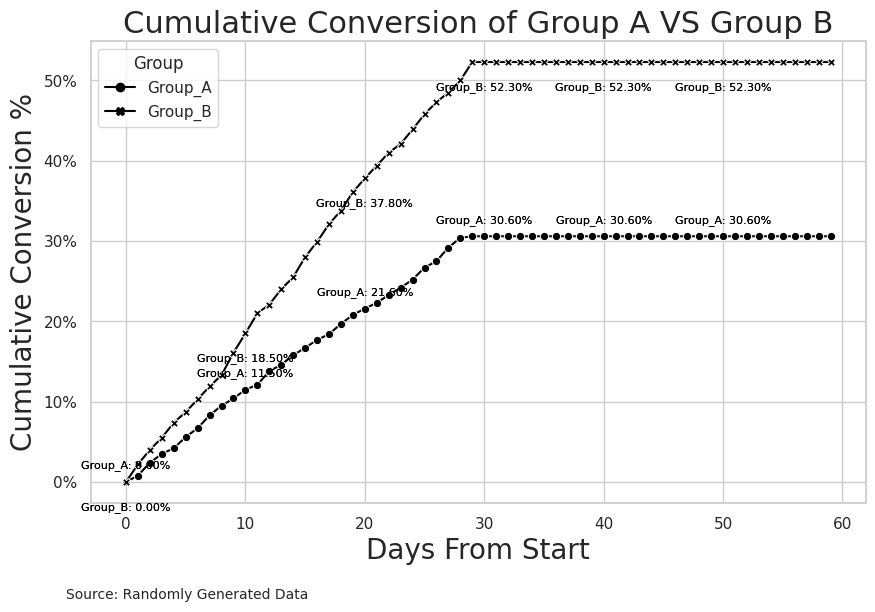

In [7]:
sns.set(style="whitegrid", font_scale=1)

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6),frameon =False)

# Plot the line chart on the primary y-axis with black color and dots
line = sns.lineplot(data=fin_df, x="X", y="Y", hue="Group", palette={'Group_A': 'black', 'Group_B': 'black'}, markers=True, style="Group", dashes=False)

#Set x-axis label and title
ax.set_xlabel('Days From Start', fontsize=20)
ax.set_ylabel('Cumulative Conversion %', fontsize=20)
ax.set_title('Cumulative Conversion of Group A VS Group B', fontsize=22)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

# Add x-axis grid lines every 10 values
ax.xaxis.set_major_locator(MultipleLocator(10))

# Add annotations for 'Group_A' and 'Group_B' every 10 ticks
for index, value in enumerate(fin_df['X']):
    if index % 10 == 0:
        group_a_value = fin_df.loc[(fin_df['X'] == value) & (fin_df['Group'] == 'Group_A'), 'Y'].values[0]
        group_b_value = fin_df.loc[(fin_df['X'] == value) & (fin_df['Group'] == 'Group_B'), 'Y'].values[0]
        
        # Format the values as percentages
        group_a_percentage = group_a_value * 100
        group_b_percentage = group_b_value * 100

        # Annotate with formatted percentages
        ax.annotate(f'Group_A: {group_a_percentage:.2f}%', (value, group_a_value), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8, color='black')
        ax.annotate(f'Group_B: {group_b_percentage:.2f}%', (value, group_b_value), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=8, color='black')

# Adding a footnote below the x-axis
footnote_text = "Source: Randomly Generated Data"
plt.figtext(0.1, -0.05, footnote_text, ha="left", fontsize=10, bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))    

# Show the plot
plt.savefig("graph2.png",transparent=True,bbox_inches='tight',pad_inches=0.05,dpi=400) 
plt.show()

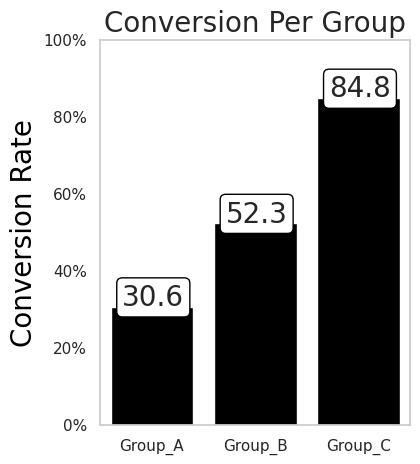

In [8]:
final_df = df

# Axis 1
y1 = final_df[['Group','IsConversion']].groupby('Group').mean()*100

x = y1.index.tolist()
y1 = y1['IsConversion']

sns.set(style="whitegrid", font_scale=1)

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(4, 5),frameon =False)

# Plot the bar chart on the primary y-axis
bar = sns.barplot(x=x, y=y1, ax=ax1, color='darkorange')
bar = sns.barplot(x=x, y=y1, ax=ax1, color='black')
ax1.set_ylabel('Conversion Rate', color='black', fontsize=20)
ax1.set_ylim([0, 100])
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

# Add values on top of the bars
for i, v in enumerate(y1):
    ax1.annotate(f'{v:,.1f}', xy=(i, v), xytext=(1, 1), ha='center', textcoords='offset points',bbox=dict(boxstyle='round,pad=0.2', edgecolor='black', facecolor='white'),fontsize=20) 

plt.xticks(rotation=0) 

# Set x-axis label and title
ax1.set_xlabel('', fontsize=20)
ax1.set_title('Conversion Per Group', fontsize=20)

# Disable the background grid lines
ax1.grid(False)
ax1.grid(False)

# Show the plot
plt.savefig("overall.png",transparent=True,bbox_inches='tight',pad_inches=0.05,dpi=400) 
plt.show()


# Experiment Test
- Calculating p-value
- Calculating required test size
- Calculating ci

The function create_sequence(num_ones, total_length) generates a sequence of zeros and ones based on two parameters: the desired number of ones (num_ones) and the total length of the sequence (total_length).

In [9]:
def create_sequence(num_ones, total_length):
    num_zeros = total_length - num_ones
    ones = repeat(1, num_ones)
    zeros = repeat(0, num_zeros)
    
    sequence = list(chain(ones, zeros))
    return sequence

This function appears to compute the p-value for an A/B test given conversion rates and sample sizes. Let's break down how it works:

Inputs:

con_conv: Conversion rate of the control group.
test_conv: Conversion rate of the test group.
con_size: Sample size of the control group.
test_size: Sample size of the test group.
Calculation Steps:

lift: Calculate the absolute difference between the conversion rates of the control and test groups. This represents the "lift" in conversion rate achieved by the test group.
scale_one and scale_two: Compute the scale values for each group using the formula for the standard error of the proportion (for a binary outcome). This is done by multiplying the conversion rate by (1 - conversion rate) and then scaling it by the sample size.
scale_val: Calculate the combined scale value for both groups by taking the square root of the sum of squares of scale_one and scale_two.
p_value: Compute the p-value using the cumulative distribution function (CDF) of the standard normal distribution (stats.norm.cdf). This is a two-tailed test, so the p-value is doubled. The loc parameter is set to 0, and scale is set to scale_val.
Output:

p_value: The probability of observing a test statistic as extreme as the observed value, under the null hypothesis that there is no difference between the control and test groups.
This function is commonly used in A/B testing to determine whether the difference in conversion rates between two groups is statistically significant. If the p-value is below a certain significance level (often 0.05), it indicates that the observed difference is unlikely to have occurred by random chance alone, and thus the test group's performance is deemed significantly different from the control group's.

In [10]:
def get_pvalue(con_conv, test_conv, con_size, test_size):
    lift = -abs(test_conv - con_conv)
    
    scale_one = con_conv * (1-con_conv) * (1/ con_size)
    scale_two = test_conv * (1-test_conv) * (1/ test_size)
    scale_val = (scale_one + scale_two) ** 0.5
    
    p_value = 2 * stats.norm.cdf(lift, loc=0, scale = scale_val)  
    return p_value


This function seems to calculate the confidence interval (CI) for a given lift (difference in conversion rates between two groups), significance level (alpha), and standard deviation (sd). Here's a breakdown:

Inputs:

lift: The observed lift (difference in conversion rates between two groups).
alpha: The significance level, often denoted as α, which represents the probability of rejecting the null hypothesis when it is true (Type I error rate).
sd: The standard deviation of the observed lift.
Calculation Steps:

val: Calculate the critical value from the standard normal distribution corresponding to the specified significance level (α/2 for a two-tailed test). This is done using the inverse of the cumulative distribution function (CDF) with (1-alpha)/2.
Compute the lower and upper bounds of the confidence interval using the formula:
Lower bound (lwr_bnd) = lift - (critical value * sd)
Upper bound (upr_bnd) = lift + (critical value * sd)
Output:

A tuple containing the lower and upper bounds of the confidence interval.
This function is used to estimate the range within which the true lift (difference in conversion rates) is likely to fall, with a specified level of confidence (1 - α). Typically, a 95% confidence interval is used (α = 0.05), but this can be adjusted as needed.

In [11]:
def get_ci(lift, alpha, sd):
    val = abs(stats.norm.ppf((1-alpha)/2))
    
    lwr_bnd = lift - val * sd
    upr_bnd = lift + val * sd
    
    return (lwr_bnd, upr_bnd)

## Get Test Size

This code calculates the sample size needed for an A/B test using power analysis. Let's break down what each part does:

Power Analysis Calculation:

sms.NormalIndPower().solve_power(...): This uses the solve_power method from the statsmodels.stats.power module to calculate the sample size needed for a two-sample z-test for proportions (A/B test).
sms.proportion_effectsize(0.10, 0.09): This calculates the effect size for the test. In this case, it's calculated as the difference between two proportions: 0.10 and 0.09. The effect size is a measure of the magnitude of the difference between groups.
power=0.8: This sets the desired power of the test to 0.8, meaning the probability of finding a statistical difference between the groups when a difference is actually present is 80%.
alpha=0.05: This sets the significance level (α) to 0.05, which is the probability of rejecting the null hypothesis when it is true.
ratio=1: This is the ratio of the number of observations in one group to the number in the other group. Here, it's set to 1, meaning equal sample sizes for both groups.
Rounding Up:

ceil(required_n): The calculated sample size is rounded up to the next whole number using the ceil function from the math module. This ensures that the sample size is an integer value.
Printing the Result:

print(required_n): Finally, it prints the calculated sample size needed for the A/B test.
This code snippet essentially performs a power analysis to determine the sample size required to detect a specified effect size with a desired level of power and significance.

In [12]:
#Power of the test (1 — β) — This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. 
#                            This is usually set at 0.8 by convention (here’s more info on statistical power, if you are curious)
#Alpha value (α) — The critical value we set earlier to 0.05
#Effect size — How big of a difference we expect there to be between the conversion rates

required_n = sms.NormalIndPower().solve_power(
    sms.proportion_effectsize(0.10, 0.09), 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

13488


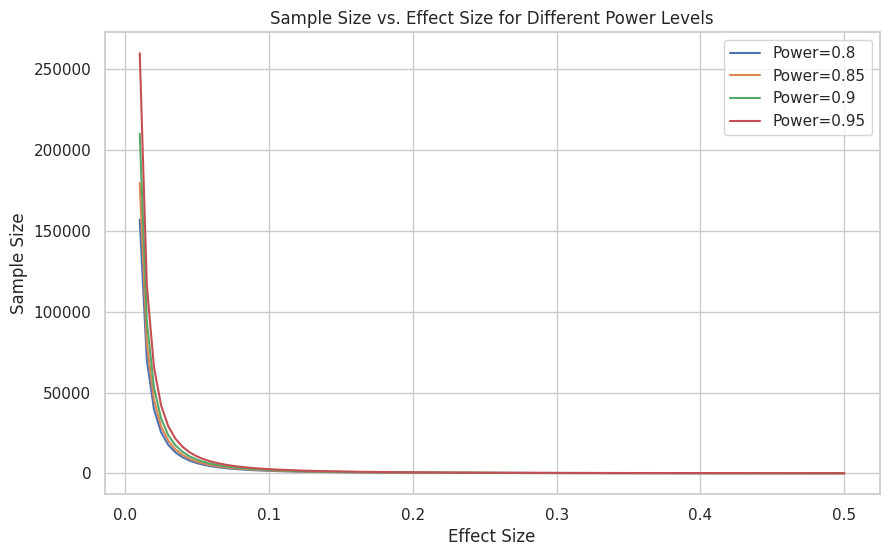

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.power as sms
from math import ceil

# Effect sizes ranging from 0.01 to 0.5
effect_sizes = np.linspace(0.01, 0.5, 100)

# Power levels to plot
power_levels = [0.8, 0.85, 0.9, 0.95]

# Calculate required sample sizes for each effect size and power level
sample_sizes = {}
for power in power_levels:
    required_n = [ceil(sms.NormalIndPower().solve_power(effect_size, power=power, alpha=0.05, ratio=1)) for effect_size in effect_sizes]
    sample_sizes[power] = required_n

# Plotting
plt.figure(figsize=(10, 6))
for power in power_levels:
    plt.plot(effect_sizes, sample_sizes[power], label=f'Power={power}')

plt.title('Sample Size vs. Effect Size for Different Power Levels')
plt.xlabel('Effect Size')
plt.ylabel('Sample Size')
plt.legend()
plt.grid(True)
plt.show()


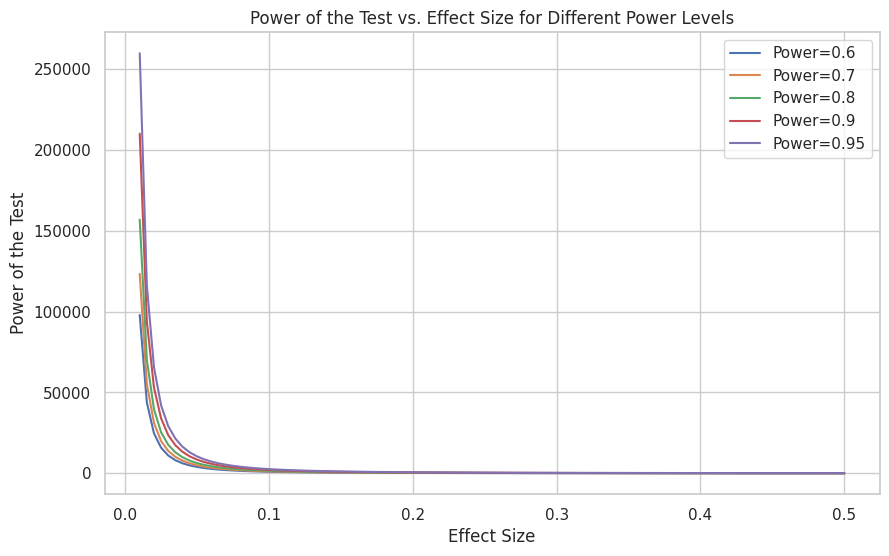

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.power as sms

# Effect sizes ranging from 0.01 to 0.5
effect_sizes = np.linspace(0.01, 0.5, 100)

# Power levels to calculate
power_levels = [0.6, 0.7, 0.8, 0.9, 0.95]

# Calculate power for each effect size and power level
powers = {}
for power in power_levels:
    calculated_powers = [sms.NormalIndPower().solve_power(effect_size, power=power, alpha=0.05, ratio=1) for effect_size in effect_sizes]
    powers[power] = calculated_powers

# Plotting
plt.figure(figsize=(10, 6))
for power in power_levels:
    plt.plot(effect_sizes, powers[power], label=f'Power={power}')

plt.title('Power of the Test vs. Effect Size for Different Power Levels')
plt.xlabel('Effect Size')
plt.ylabel('Power of the Test')
plt.legend()
plt.grid(True)
plt.show()


## P-Value

In [15]:
con_size = 82000
test_size = 82000

con_conv = 1000/con_size
test_conv = 1050/test_size

con_conv = 0.01
test_conv = 0.011

get_pvalue(con_conv, test_conv, con_size, test_size)

0.04697477066748545

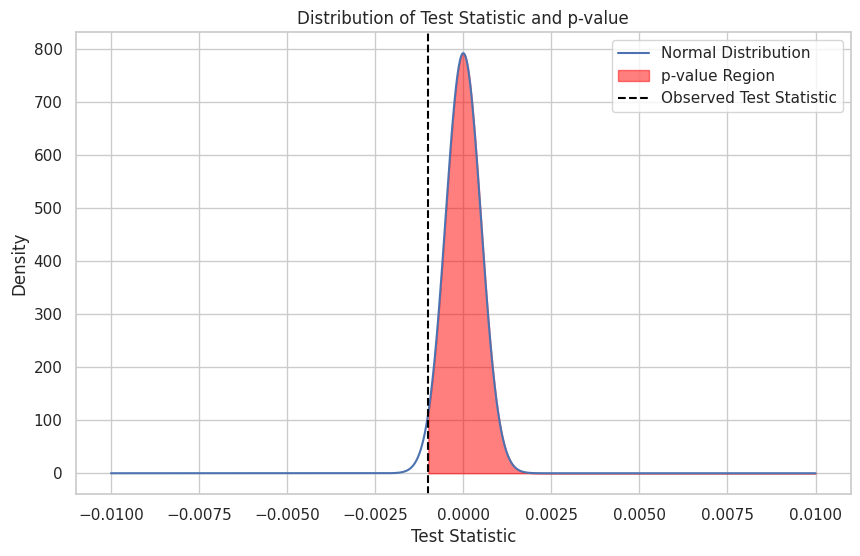

p-value: 0.04697477066748545


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def get_pvalue(con_conv, test_conv, con_size, test_size):
    lift = -abs(test_conv - con_conv)
    
    scale_one = con_conv * (1-con_conv) * (1/ con_size)
    scale_two = test_conv * (1-test_conv) * (1/ test_size)
    scale_val = (scale_one + scale_two) ** 0.5
    
    p_value = 2 * stats.norm.cdf(lift, loc=0, scale=scale_val)  
    return p_value

# Given conversion rates and sample sizes
con_size = 82000
test_size = 82000
con_conv = 0.01
test_conv = 0.011

# Calculate p-value
p_value = get_pvalue(con_conv, test_conv, con_size, test_size)

# Calculate lift and scale_val
lift = -abs(test_conv - con_conv)
scale_one = con_conv * (1-con_conv) * (1/ con_size)
scale_two = test_conv * (1-test_conv) * (1/ test_size)
scale_val = (scale_one + scale_two) ** 0.5

# Plotting
x = np.linspace(-0.01, 0.01, 1000)
y = stats.norm.pdf(x, loc=0, scale=scale_val)

plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Normal Distribution')
plt.fill_between(x, y, where=(x >= lift), color='red', alpha=0.5, label='p-value Region')
plt.axvline(x=lift, color='black', linestyle='--', label='Observed Test Statistic')
plt.title('Distribution of Test Statistic and p-value')
plt.xlabel('Test Statistic')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

print("p-value:", p_value)


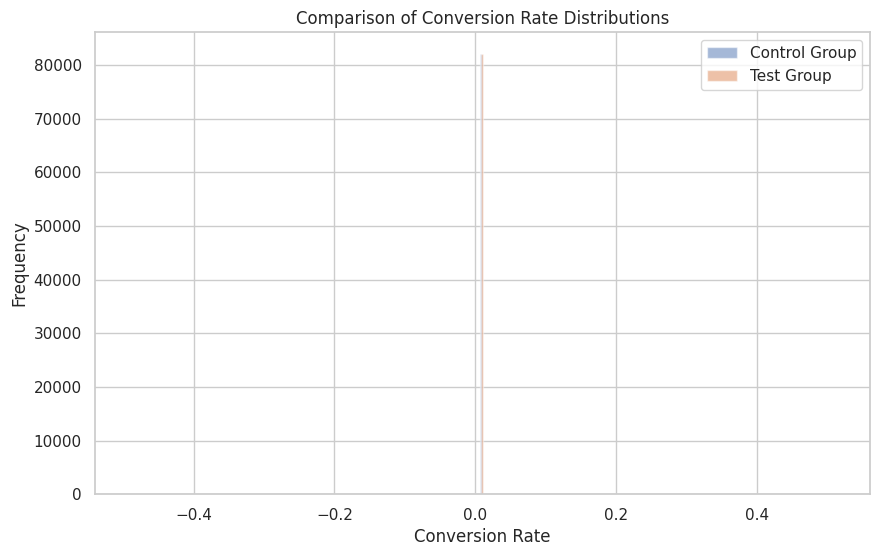

In [17]:
import matplotlib.pyplot as plt

# Given conversion rates
con_conv = 0.01
test_conv = 0.011

# Plotting
plt.figure(figsize=(10, 6))

# Histogram for control group
plt.hist([con_conv]*con_size, bins=300, alpha=0.5, label='Control Group')

# Histogram for test group
plt.hist([test_conv]*test_size, bins=300, alpha=0.5, label='Test Group')

plt.title('Comparison of Conversion Rate Distributions')
plt.xlabel('Conversion Rate')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


## Confidence Interval

In [18]:
con_size = 50000
test_size = 50000

con_conv = 1000/con_size
test_conv = 1100/test_size

lift_mean = test_conv - con_conv
lift_variance = (1 - test_conv) * test_conv /test_size + (1 - con_conv) * con_conv / con_size
lift_sd = lift_variance**0.5
get_ci(lift_mean, 0.95, lift_sd)

(0.00022266817464121282, 0.003777331825358784)

## P-Value and Confidence Interval

In [19]:
n_con = 50000
n_treat = 50000

suc_con = 1000
suc_treat = 1088

successes = [suc_con, suc_treat]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Conv Con: {suc_con/n_con:.4f}')
print(f'Conv Treat: {suc_treat/n_treat:.4f}')
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.4f}, {upper_con:.4f}]')
print(f'ci 95% for treatment group: [{lower_treat:.4f}, {upper_treat:.4f}]')

Conv Con: 0.0200
Conv Treat: 0.0218
z statistic: -1.95
p-value: 0.052
ci 95% for control group: [0.0188, 0.0212]
ci 95% for treatment group: [0.0205, 0.0230]


Reject null hypothesis: There is a significant difference.
p-value 0.04907913085485977
Confidence interval for A: (0.018772826464560546, 0.021227173535439455)
Confidence interval for B: (0.020500544599091685, 0.023059455400908316)


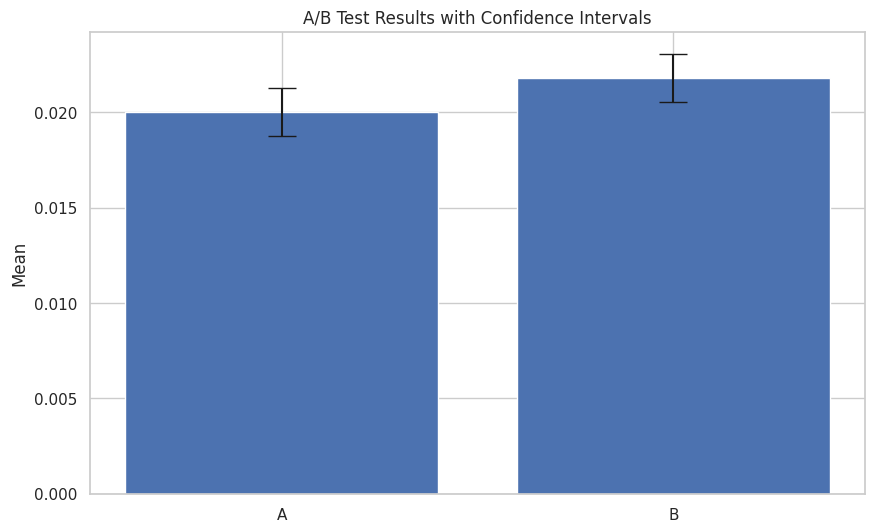

In [20]:
data_a = np.array(create_sequence(1000, 50000))  
data_b = np.array(create_sequence(1089, 50000))  

t_stat, p_value = stats.ttest_ind(data_a, data_b)
alpha = 0.05  # Significance level

if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference.")
    print("p-value",p_value)
else:
    print("Fail to reject null hypothesis: No significant difference.")
    print("p-value",p_value)
    
confidence_level = 0.95

# Calculate means and standard errors
mean_a = np.mean(data_a)
mean_b = np.mean(data_b)
std_a = np.std(data_a, ddof=1)  # Use ddof=1 for sample standard deviation
std_b = np.std(data_b, ddof=1)
n_a = len(data_a)
n_b = len(data_b)

# Calculate standard errors
se_a = std_a / np.sqrt(n_a)
se_b = std_b / np.sqrt(n_b)

# Calculate confidence intervals
ci_a = stats.t.interval(confidence_level, df=n_a - 1, loc=mean_a, scale=se_a)
ci_b = stats.t.interval(confidence_level, df=n_b - 1, loc=mean_b, scale=se_b)

print(f"Confidence interval for A: {ci_a}")
print(f"Confidence interval for B: {ci_b}")

plt.figure(figsize=(10, 6))
plt.bar(['A', 'B'], [mean_a, mean_b], yerr=[(mean_a - ci_a[0], ci_a[1] - mean_a), (mean_b - ci_b[0], ci_b[1] - mean_b)], capsize=10)
plt.ylabel('Mean')
plt.title('A/B Test Results with Confidence Intervals')
plt.show()